In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

import lightgbm as lgb

import pickle

# Check on the validation set

In [2]:
X = pd.read_csv('X_train_processed.csv')
y = pd.read_csv('y_train.csv')

In [3]:
X = X.set_index('id')
y = y.set_index('id')

In [4]:
drop_columns = [
    'HRV_MeanNN',
    'HRV_MedianNN',
    'HRV_LF',
    'HRV_LFHF',
    'HRV_LFn',
    'HRV_SDANN1',
    'HRV_SDANN2',
    'HRV_SDANN5',
    'HRV_SDNNI1',
    'HRV_SDNNI2',
    'HRV_SDNNI5',
    'HRV_ULF',
    'HRV_VLF',   
]

In [5]:
X = X.drop(columns=drop_columns)

In [6]:
# split the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [7]:
xgb_model = pickle.load(open("xgboost.pkl", "rb"))

In [8]:
lgbm_model = pickle.load(open("lgbm.pkl", "rb"))

In [9]:
xgb_y_pred_proba = xgb_model.predict_proba(X_val)
xgb_y_pred_proba

array([[9.1898429e-01, 7.8463774e-05, 8.0908857e-02, 2.8352730e-05],
       [9.2465347e-01, 3.7898837e-05, 7.5279124e-02, 2.9503233e-05],
       [8.8695401e-01, 2.7410453e-04, 1.1274728e-01, 2.4638208e-05],
       ...,
       [8.7489128e-01, 1.9440691e-04, 1.2487507e-01, 3.9283015e-05],
       [9.9744993e-01, 5.2232285e-06, 2.5315015e-03, 1.3276760e-05],
       [8.1789801e-03, 9.0489804e-05, 9.9170786e-01, 2.2672863e-05]],
      dtype=float32)

In [10]:
lgbm_y_pred_proba = lgbm_model.predict(X_val)
lgbm_y_pred_proba

array([[0.77009524, 0.00626543, 0.22135941, 0.00227993],
       [0.70136332, 0.00813263, 0.28752256, 0.00298149],
       [0.80148917, 0.00804548, 0.18748153, 0.00298382],
       ...,
       [0.88404733, 0.00416769, 0.11034577, 0.00143921],
       [0.94397564, 0.0041372 , 0.05036116, 0.00152599],
       [0.06402369, 0.00608218, 0.92819874, 0.00169539]])

In [11]:
ensemble_y_pred_proba = (xgb_y_pred_proba + lgbm_y_pred_proba) / 2.

In [12]:
ensemble_y_pred_proba

array([[8.44539765e-01, 3.17194631e-03, 1.51134132e-01, 1.15414007e-03],
       [8.13008397e-01, 4.08526260e-03, 1.81400842e-01, 1.50549715e-03],
       [8.44221588e-01, 4.15979342e-03, 1.50114406e-01, 1.50422952e-03],
       ...,
       [8.79469306e-01, 2.18104969e-03, 1.17610420e-01, 7.39244912e-04],
       [9.70712789e-01, 2.07121204e-03, 2.64463310e-02, 7.69635682e-04],
       [3.61013370e-02, 3.08633319e-03, 9.59953300e-01, 8.59031750e-04]])

In [13]:
ensemble_y_pred = [np.argmax(line) for line in ensemble_y_pred_proba]

In [14]:
# view accuracy
from sklearn.metrics import f1_score
accuracy = f1_score(ensemble_y_pred, y_val, average='micro')
print('Ensemble Model accuracy score: {0:0.4f}'.format(accuracy))

Ensemble Model accuracy score: 0.8040


In [15]:
cm_df = confusion_matrix(y_val, ensemble_y_pred)
cm_df = normalize(cm_df, norm='l1')

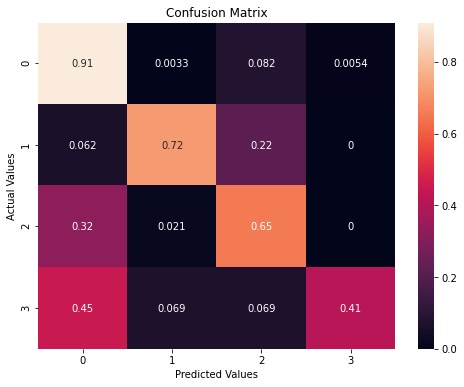

In [16]:
#Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Output 

In [17]:
X_test = pd.read_csv('X_test_processed.csv')
X_test = X_test.set_index('id')
X_test = X_test.drop(columns=drop_columns)

In [18]:
X_test

,HRV_AI,HRV_ApEn,HRV_C1a,HRV_C1d,HRV_C2a,HRV_C2d,HRV_CD,HRV_CMSE,HRV_CSI,HRV_CSI_Modified,...,mean_QRS_complexes,mean_RR_intervals,median_QRS_complexes,median_RR_intervals,min_QRS_complexes,min_RR_intervals,range_QRS_complexes,range_RR_intervals,std_QRS_complexes,std_RR_intervals
id,,,,,,,,,,,,,,,,,,,,,
0,41.050276,0.436130,0.706169,0.293831,0.517418,0.482582,0.969898,NaN,4.354750,1418.528570,...,65.296296,257.258065,64.0,252.0,34.0,237.0,88.0,55.0,21.183178,17.439236
1,50.371122,0.331311,0.462957,0.537043,0.567535,0.432465,0.740712,NaN,1.163351,367.130962,...,103.750000,322.058824,85.5,322.0,70.0,258.0,93.0,113.0,34.493659,20.746284
2,51.369009,0.139583,0.515833,0.484167,0.427153,0.572847,0.754727,NaN,0.799545,808.105413,...,45.758621,281.142857,39.0,293.5,25.0,120.0,74.0,393.0,19.404328,84.549949
3,51.208644,0.330394,0.495818,0.504182,0.472865,0.527135,0.995753,NaN,1.638217,143.534395,...,72.307692,289.500000,67.0,290.0,33.0,278.0,90.0,21.0,21.808201,5.267827
4,49.087654,0.322666,0.375753,0.624247,0.838816,0.161184,0.920702,NaN,1.536799,997.007655,...,58.214286,286.035714,51.5,299.0,39.0,147.0,74.0,172.0,18.750918,39.600218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3406,53.412226,0.289623,0.365092,0.634908,0.790939,0.209061,0.502607,NaN,0.768455,347.231683,...,39.804878,206.400000,38.0,212.5,25.0,99.0,41.0,216.0,10.196172,39.713222
3407,54.809639,0.602064,0.533117,0.466883,0.271503,0.728497,0.857222,NaN,1.431904,1556.803351,...,43.133333,262.774194,42.0,294.0,26.0,93.0,65.0,239.0,10.088718,70.104397
3408,51.583326,0.442048,0.460215,0.539785,0.524823,0.475177,1.447147,NaN,2.097266,620.160851,...,45.714286,227.840580,47.0,228.0,33.0,187.0,27.0,76.0,7.174533,17.218648


In [19]:
xgb_y_pred_proba = xgb_model.predict_proba(X_test)
xgb_y_pred_proba

array([[9.9605680e-01, 4.5326146e-06, 3.9360053e-03, 2.6389137e-06],
       [2.9311258e-01, 1.6184849e-03, 7.0507932e-01, 1.8961150e-04],
       [1.6280666e-01, 3.1328336e-03, 4.0651637e-01, 4.2754412e-01],
       ...,
       [9.7168928e-01, 7.4557116e-04, 2.7534284e-02, 3.0892865e-05],
       [9.9949574e-01, 8.8677461e-06, 4.9256638e-04, 2.8348804e-06],
       [5.2170406e-05, 9.9920803e-01, 7.2948652e-04, 1.0363670e-05]],
      dtype=float32)

In [20]:
lgbm_y_pred_proba = lgbm_model.predict(X_test)
lgbm_y_pred_proba

array([[0.95122652, 0.0031201 , 0.04450253, 0.00115084],
       [0.43980818, 0.00703536, 0.55058905, 0.00256741],
       [0.34264061, 0.0236539 , 0.32677663, 0.30692887],
       ...,
       [0.95218455, 0.00463417, 0.0417331 , 0.00144819],
       [0.93321456, 0.00430839, 0.06088791, 0.00158914],
       [0.0203316 , 0.93163804, 0.04518653, 0.00284383]])

In [21]:
xgb_y_pred = [np.argmax(line) for line in xgb_y_pred_proba]

In [22]:
lgbm_y_pred = [np.argmax(line) for line in lgbm_y_pred_proba]

In [23]:
for i in range(len(xgb_y_pred)):
    if xgb_y_pred[i] != lgbm_y_pred[i]:
        print(i, xgb_y_pred[i], xgb_y_pred_proba[i], lgbm_y_pred[i], lgbm_y_pred_proba[i])

2 3 [0.16280666 0.00313283 0.40651637 0.42754412] 0 [0.34264061 0.0236539  0.32677663 0.30692887]
4 2 [4.6538424e-01 1.5615321e-03 5.3287721e-01 1.7707888e-04] 0 [0.65736649 0.02469367 0.31465457 0.00328527]
22 2 [3.4225568e-01 6.7620509e-05 6.5762126e-01 5.5448600e-05] 0 [0.60373143 0.00737952 0.38639669 0.00249237]
42 0 [7.5360942e-01 4.2763175e-03 2.4167895e-01 4.3534071e-04] 2 [0.34395033 0.04933285 0.60152251 0.00519431]
44 2 [4.3436897e-01 1.8199778e-04 5.6542903e-01 1.9975769e-05] 0 [0.66424214 0.00491581 0.32903378 0.00180827]
47 0 [5.1259887e-01 2.1712108e-01 2.7001792e-01 2.6213814e-04] 2 [0.277604   0.23307367 0.48400267 0.00531966]
49 0 [6.9534034e-01 9.6742669e-04 3.0312887e-01 5.6339672e-04] 2 [0.38955438 0.02217578 0.58373564 0.0045342 ]
79 0 [0.5047438  0.00083474 0.49177223 0.00264918] 2 [0.47730498 0.01743514 0.49178032 0.01347955]
93 2 [0.41199467 0.01445259 0.5673405  0.00621224] 0 [0.58694289 0.04129382 0.35095157 0.02081172]
116 2 [0.12203132 0.2034845  0.589164  

In [24]:
ensemble_y_pred_proba = (xgb_y_pred_proba + lgbm_y_pred_proba) / 2.

In [25]:
ensemble_y_pred_proba

array([[9.73641659e-01, 1.56231864e-03, 2.42192683e-02, 5.76740260e-04],
       [3.66460376e-01, 4.32692385e-03, 6.27834185e-01, 1.37851011e-03],
       [2.52723633e-01, 1.33933672e-02, 3.66646500e-01, 3.67236492e-01],
       ...,
       [9.61936917e-01, 2.68986979e-03, 3.46336899e-02, 7.39539308e-04],
       [9.66355153e-01, 2.15862868e-03, 3.06902394e-02, 7.95985982e-04],
       [1.01918848e-02, 9.65423038e-01, 2.29580091e-02, 1.42709491e-03]])

In [26]:
ensemble_y_pred = [np.argmax(line) for line in ensemble_y_pred_proba]
y_test = ensemble_y_pred

In [27]:
data_y_test = {
    'id': [i for i in range(len(y_test))],
    'y': y_test
}
df_y_test = pd.DataFrame(data_y_test)
df_y_test.to_csv('y_test.csv', index=False)

In [28]:
df_y_test

,id,y
0,0,0
1,1,2
2,2,3
3,3,0
4,4,0
...,...,...
3406,3406,0
3407,3407,0
3408,3408,0
3409,3409,0
